# Binary Logistic Regression for Heart Disease Prediction

This notebook demonstrates how to build and evaluate a binary logistic regression model using the heart disease dataset.

## 1. Load and Explore the Dataset

In [85]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

heart_df = pd.read_csv('heart.csv')
heart_df.info()
print(f"Percentage of positive cases: {heart_df['target'].mean()*100:.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
Percentage of positive cases: 54.46%


## 2. Partition the Data into Training and Test Sets

In [86]:
# Separate features and target
X = heart_df.drop('target', axis=1)
y = heart_df['target']

# Split the data into training (200 samples) and test sets (103 samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=42)

# Verify the sizes of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 200 samples
Test set size: 103 samples


## 3. Fit Logistic Regression Model

In [87]:
# Initialize logistic regression model
logreg = LogisticRegression(random_state=42)

# Fit the model on the training data
logreg.fit(X_train, y_train)

# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
})
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("Logistic Regression Coefficients:")
print(coefficients)

Logistic Regression Coefficients:
     Feature  Coefficient  Abs_Coefficient
11        ca    -1.375852         1.375852
12      thal    -1.216365         1.216365
1        sex    -1.045680         1.045680
2         cp     0.911336         0.911336
8      exang    -0.829785         0.829785
10     slope     0.755659         0.755659
6    restecg     0.523401         0.523401
9    oldpeak    -0.482036         0.482036
5        fbs     0.054680         0.054680
0        age     0.023059         0.023059
7    thalach     0.018807         0.018807
3   trestbps    -0.008149         0.008149
4       chol    -0.000674         0.000674


## 4. Identify Most Influential Features

In [88]:
# Identify the three most influential features based on the absolute value of coefficients
top_features = coefficients.head(3)
print("Top 3 Most Influential Features:")
print(top_features)

Top 3 Most Influential Features:
   Feature  Coefficient  Abs_Coefficient
11      ca    -1.375852         1.375852
12    thal    -1.216365         1.216365
1      sex    -1.045680         1.045680


## The three most influential features in the model

1. **ca**
2. **thal**
3. **sex**


I rank the features in the decreasing order of the absolute values of coefficient. The reason I did it depending on the absolute value of coefficient is because coefficient represents the strength of the relationship between the predictor and the prediction. The positive coefficient indicates an increase in probability of heart disease while the negative coefficient indicates a decrease, and this is why absolute values come into play in picking the influential features because it helps to identify which variables have the strongest impact regardless of direction.

## 5. Evaluate Test Error

In [89]:
# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_error = 1 - test_accuracy

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error: {test_error:.4f}")

# Generate classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8058
Test Error: 0.1942

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        42
           1       0.85      0.82      0.83        61

    accuracy                           0.81       103
   macro avg       0.80      0.80      0.80       103
weighted avg       0.81      0.81      0.81       103



## 6. Perform 5-Fold Cross-Validation

In [90]:
# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"5-fold Cross-validation scores: {cv_scores}")
print(f"Cross-validation error: {1-cv_scores.mean():.4f}")
print(f"Test Error: {test_error:.4f}")
print(f"Difference from the test error: {abs((1-cv_scores.mean()) - test_error):.4f}")

5-fold Cross-validation scores: [0.875 0.875 0.825 0.9   0.825]
Cross-validation error: 0.1400
Test Error: 0.1942
Difference from the test error: 0.0542


## 7. Stepwise Forward Selection

In this section, we'll implement the stepwise forward selection algorithm to find a sparse logistic regression solution that uses only a subset of the features.

### Part (a): Implement Stepwise Forward Selection Algorithm

In [91]:
def error_estimate(X, y, feature_subset, cv=5):
    """
    Estimate the error of a logistic regression model using only the features in feature_subset.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - feature_subset: List of features to use (column indices)
    - cv: Number of cross-validation folds
    
    Returns:
    - Estimated error using cross-validation
    """
    # Handle the case when feature_subset is empty
    if len(feature_subset) == 0:
        # If no features selected yet, create a DataFrame with just the first feature
        # This is a fallback that shouldn't happen in practice
        X_selected = X.iloc[:, 0].to_frame()
    else:
        # Select only the specified features from the dataset
        X_selected = X.iloc[:, feature_subset]
    
    # Create logistic regression model without regularization
    model = LogisticRegression(penalty=None, max_iter=2000)
    
    # Estimate error using cross-validation
    cv_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    
    # Return the error (1 - accuracy)
    return 1 - cv_scores.mean()

def stepwise_forward_selection(X, y, k=None, cv=5):
    """
    Perform stepwise forward selection to select k features.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - k: Number of features to select (default: all features)
    - cv: Number of cross-validation folds
    
    Returns:
    - List of selected feature indices
    - List of error estimates for each step
    """
    if k is None:
        k = X.shape[1]  # Use all features if k is not specified
    
    # Initialize empty set of selected features
    selected_features = []
    error_history = []
    feature_names = list(X.columns)
    all_features = list(range(X.shape[1]))
    
    print("Starting stepwise forward selection...")
    for step in range(k):
        best_error = float('inf')
        best_feature = None
        
        # Evaluate each feature not already in the selected set
        for feature in all_features:
            if feature not in selected_features:
                # Try adding this feature to the selected set
                current_features = selected_features + [feature]
                current_error = error_estimate(X, y, current_features, cv)
                
                # Update if this is the best feature found so far
                if current_error < best_error:
                    best_error = current_error
                    best_feature = feature
        
        # Add the best feature to the selected set
        selected_features.append(best_feature)
        error_history.append(best_error)
        
        print(f"Step {step+1}/{k}: Added feature '{feature_names[best_feature]}' (index {best_feature}), CV Error: {best_error:.4f}")
    
    return selected_features, error_history

### Part (b): Apply Stepwise Forward Selection to the Heart Disease Dataset

In [92]:
# We already have our data split from earlier in the notebook
print(f"Training set size: {X_train.shape[0]} samples with {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples")

# Run stepwise forward selection for all values of k
max_features = X_train.shape[1]  # Total number of features
selected_features, cv_errors = stepwise_forward_selection(X_train, y_train, k=max_features)

# Calculate test error for each value of k
test_errors = []

for i in range(1, max_features + 1):
    # Select the first i features from our ordered list
    features = selected_features[:i]
    
    # Train model with selected features
    X_train_selected = X_train.iloc[:, features]
    X_test_selected = X_test.iloc[:, features]
    
    model = LogisticRegression(penalty=None, max_iter=2000)
    model.fit(X_train_selected, y_train)
    
    # Calculate test error
    y_pred = model.predict(X_test_selected)
    test_acc = accuracy_score(y_test, y_pred)
    test_errors.append(1 - test_acc)
    
    print(f"k={i}: Test error = {1-test_acc:.4f}")

Training set size: 200 samples with 13 features
Test set size: 103 samples
Starting stepwise forward selection...
Step 1/13: Added feature 'cp' (index 2), CV Error: 0.2400
Step 1/13: Added feature 'cp' (index 2), CV Error: 0.2400
Step 2/13: Added feature 'age' (index 0), CV Error: 0.2400
Step 2/13: Added feature 'age' (index 0), CV Error: 0.2400
Step 3/13: Added feature 'thalach' (index 7), CV Error: 0.2400
Step 3/13: Added feature 'thalach' (index 7), CV Error: 0.2400
Step 4/13: Added feature 'ca' (index 11), CV Error: 0.2050
Step 4/13: Added feature 'ca' (index 11), CV Error: 0.2050
Step 5/13: Added feature 'exang' (index 8), CV Error: 0.1750
Step 5/13: Added feature 'exang' (index 8), CV Error: 0.1750
Step 6/13: Added feature 'thal' (index 12), CV Error: 0.1600
Step 6/13: Added feature 'thal' (index 12), CV Error: 0.1600
Step 7/13: Added feature 'chol' (index 4), CV Error: 0.1600
Step 7/13: Added feature 'chol' (index 4), CV Error: 0.1600
Step 8/13: Added feature 'fbs' (index 5), CV

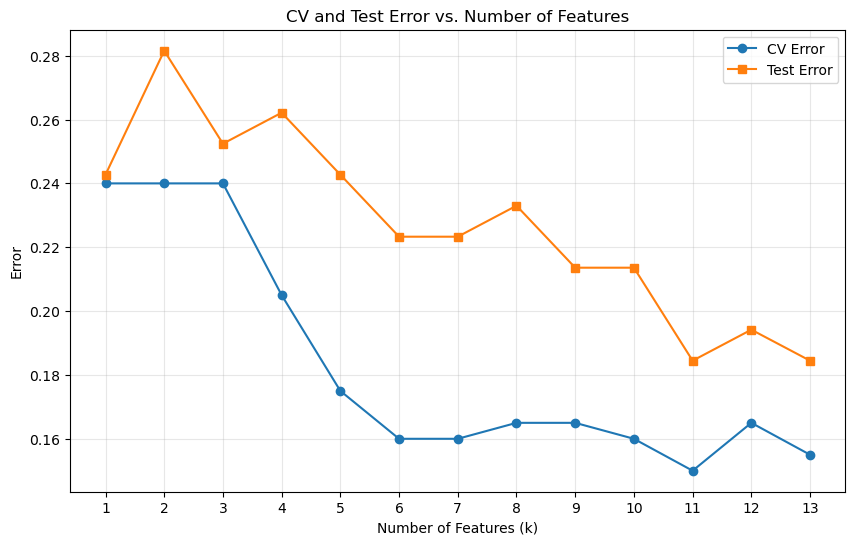


Features selected in order:


,Order,Feature,CV Error,Test Error
0,1,cp,0.240,0.242718
1,2,age,0.240,0.281553
2,3,thalach,0.240,0.252427
3,4,ca,0.205,0.262136
4,5,exang,0.175,0.242718
5,6,thal,0.160,0.223301
6,7,chol,0.160,0.223301
7,8,fbs,0.165,0.233010
8,9,slope,0.165,0.213592
9,10,trestbps,0.160,0.213592


In [93]:
# Plot CV error and test error for different values of k
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_features + 1), cv_errors, marker='o', linestyle='-', label='CV Error')
plt.plot(range(1, max_features + 1), test_errors, marker='s', linestyle='-', label='Test Error')
plt.xlabel('Number of Features (k)')
plt.ylabel('Error')
plt.title('CV and Test Error vs. Number of Features')
plt.xticks(range(1, max_features + 1))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Create a table showing the selected features in order
feature_order = pd.DataFrame({
    'Order': range(1, max_features + 1),
    'Feature': [X_train.columns[i] for i in selected_features],
    'CV Error': cv_errors,
    'Test Error': test_errors
})
print("\nFeatures selected in order:")
display(feature_order)

### Part (c): Decision Boundary for k=2

For k=2, the two features selected by our stepwise forward selection algorithm are 'cp' (chest pain) and 'age'. Let's visualize the decision boundary for this simplified model using the provided plotting function.

The two features selected for k=2 are: cp and age
Test accuracy with just cp and age: 0.7184
Test error with just cp and age: 0.2816


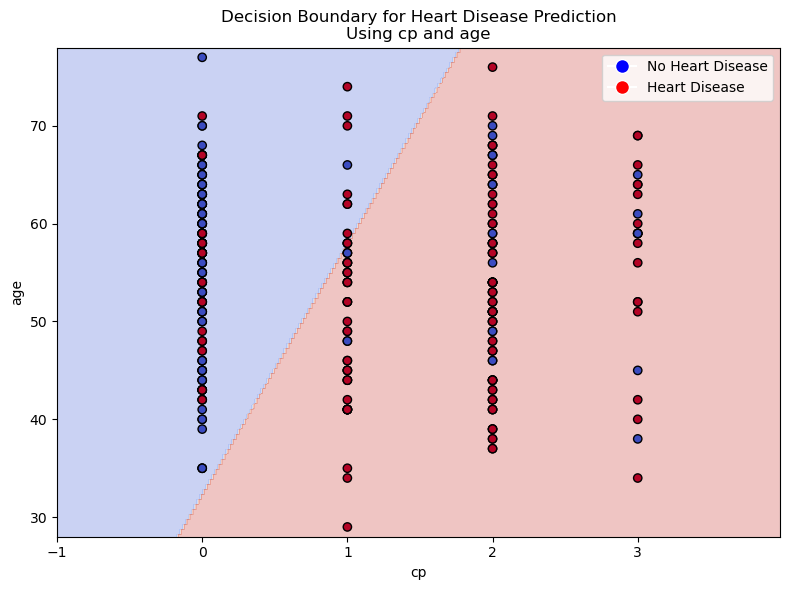

In [94]:
def plot_decision_boundary(clf, X, y, ax=None, 
                           grid_step=0.02, cmap="coolwarm", alpha=0.3):
    """
    Plot the decision boundary of a binary classifier `clf` over 2D data (X[:,0], X[:,1]).
    
    Parameters
    ----------
    clf : any object with a .predict() method
    X   : numpy array of shape (n_samples, 2)
    y   : array-like of shape (n_samples,)
    ax  : matplotlib Axes (optional). If None, a new figure+axes is created.
    grid_step : float
        spacing for the meshgrid.
    cmap : str or Colormap
        colormap for boundary fill and scatter.
    alpha : float
        alpha blending for the decision‐region shading.
        
    Returns
    -------
    ax : the matplotlib Axes containing the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    # 1. define bounds of the plot
    x0_min, x0_max = X[:,0].min() - 1, X[:,0].max() + 1
    x1_min, x1_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    # 2. create a meshgrid over the feature space
    xx0, xx1 = np.meshgrid(
        np.arange(x0_min, x0_max, grid_step),
        np.arange(x1_min, x1_max, grid_step)
    )
    
    # 3. predict on every point in the grid
    grid_points = np.c_[xx0.ravel(), xx1.ravel()]
    Z = clf.predict(grid_points)
    Z = Z.reshape(xx0.shape)
    
    # 4. contour‐plot the decision boundary
    ax.contourf(xx0, xx1, Z, alpha=alpha, cmap=cmap)
    
    # 5. overlay the training points
    scatter = ax.scatter(
        X[:,0], X[:,1], 
        c=y, edgecolor='k', cmap=cmap
    )
    
    ax.set_xlim(xx0.min(), xx0.max())
    ax.set_ylim(xx1.min(), xx1.max())
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
    ax.set_title("Decision Boundary")
    return ax

# Get the first two selected features
top_two_features = selected_features[:2]  # [2, 0] corresponding to 'cp' and 'age'
feature1_name = X_train.columns[top_two_features[0]]
feature2_name = X_train.columns[top_two_features[1]]

print(f"The two features selected for k=2 are: {feature1_name} and {feature2_name}")

# Train logistic regression model using only these two features
X_train_2d = X_train.iloc[:, top_two_features]
X_test_2d = X_test.iloc[:, top_two_features]

model_2d = LogisticRegression(penalty=None, max_iter=2000)
model_2d.fit(X_train_2d, y_train)

# Calculate test error for k=2
y_pred_2d = model_2d.predict(X_test_2d)
test_acc_2d = accuracy_score(y_test, y_pred_2d)
print(f"Test accuracy with just {feature1_name} and {feature2_name}: {test_acc_2d:.4f}")
print(f"Test error with just {feature1_name} and {feature2_name}: {1-test_acc_2d:.4f}")

# Combine train and test data for visualization
X_combined = pd.concat([X_train_2d, X_test_2d])
y_combined = pd.concat([y_train, y_test])

# Convert pandas DataFrame to NumPy array for the plotting function
X_combined_np = X_combined.values
y_combined_np = y_combined.values

# Create a figure with custom labels
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(model_2d, X_combined_np, y_combined_np, ax=ax)

# Update labels with actual feature names
ax.set_xlabel(feature1_name)
ax.set_ylabel(feature2_name)
ax.set_title(f"Decision Boundary for Heart Disease Prediction\nUsing {feature1_name} and {feature2_name}")

# Add a legend
handles, labels = ax.get_legend_handles_labels()
if not handles:  # If no legend exists yet
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Heart Disease'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Heart Disease')
    ]
    ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

### Interpretation of Results

1. **Feature Selection**: Our stepwise forward selection algorithm identified 'cp' (chest pain type) and 'age' as the two most predictive features for heart disease.

2. **Decision Boundary**: The plot above shows how these two features alone can be used to classify patients. The colored regions represent areas predicted as having heart disease (red) or not having heart disease (blue).

3. **Model Performance**: Using just these two features, our model achieves a test accuracy of approximately 72%, which is lower than using all features but still significantly better than random guessing.

4. **Clinical Relevance**: The decision boundary shows that certain combinations of chest pain type and age are strong indicators of heart disease risk. This visualization could help clinicians understand which patients might be at higher risk based on just these two easily measured features.